In [1]:
import pyvisa
import datetime
import json
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Connect to keithleys
rm = pyvisa.ResourceManager()
print(rm.list_resources())

vsource = rm.open_resource('GPIB1::9::INSTR')

print("Using " + vsource.query('*IDN?'))


('TCPIP0::18.25.29.125::inst0::INSTR', 'TCPIP0::K-CX3300-ERIAL.local::hislip0::INSTR', 'TCPIP0::K-CX3300-ERIAL.local::inst0::INSTR', 'ASRL1::INSTR', 'ASRL4::INSTR', 'GPIB1::9::INSTR')
Using Keithley Instruments Inc., Model 2657A, 1409200, 1.1.8



In [3]:
vsource.write('smua.reset()')


14

In [12]:
# experiment_name = 'test'
data_dir = 'C://Users//kashkin//Desktop//keithley data//'
current_limit = 70e-3
voltage_limit = 3.2e3

notes = 'jorge test'
total_time = 10
set_voltage = 2
measurement_count = 1
filter_measurement_count = 5
experiment_name = '{time} s {voltage} v'.format(time=total_time,voltage=set_voltage)
nplc = 1 # nplc/60 is the period of the measurement


In [13]:
# Configure as voltage source
vsource.write(' \
    smua.source.func = smua.OUTPUT_DCVOLTS \n\
    display.smua.measure.func = display.MEASURE_DCAMPS \n\
    smua.measure.autozero = smua.AUTOZERO_AUTO \n\
    smua.measure.autorangei = smua.AUTORANGE_OFF \n\
    smua.measure.rangei = {i_lim} \n\
    smua.measure.rangev = {v_lim} \n\
    smua.source.limiti = {i_lim} \n\
    smua.measure.adc = smua.ADC_INTEGRATE \n\
    smua.measure.nplc = {nplc} \n\
    smua.measure.delay = smua.DELAY_OFF \n\
    smua.measure.count = {m_count} \n\
    smua.measure.filter.count = {f_count} \n\
    smua.measure.filter.enable = smua.FILTER_ON \n\
    smua.measure.filter.type = smua.FILTER_REPEAT_AVG \
    '.format(i_lim = current_limit, v_lim = voltage_limit, m_count = measurement_count, nplc=nplc, f_count = filter_measurement_count))

579

In [14]:
aggregate_data = {'notes':notes,'voltage':set_voltage,'measured_voltages':[],'measured_currents':[],'times':[]}


In [15]:
# Conduct iteration of voltages applied to emitter with extractor set as ground
start_time = float(datetime.datetime.now().timestamp())
elapsed_time = 0

vsource.write('smua.source.levelv = %s'%set_voltage)

while elapsed_time < total_time:
        vsource.write('ireading, vreading = smua.measure.iv(smua.nvbuffer1, smua.nvbuffer2)')

        measured_current = float(vsource.query("print(ireading)")[:-1])
        measured_voltage = float(vsource.query("print(vreading)")[:-1])

        aggregate_data['measured_voltages'].append(measured_voltage)

        aggregate_data['measured_currents'].append(measured_current)

        aggregate_data['times'].append(elapsed_time)

        elapsed_time = float(datetime.datetime.now().timestamp()) - start_time

vsource.write('smua.source.levelv = 0')


24

In [16]:
# dts = []
# for i in range(len(aggregate_data['times']) - 1):
#     dts.append(aggregate_data['times'][i+1] - aggregate_data['times'][i])
# print(np.average(dts))
# print(1/np.average(dts))

In [17]:
# plt.hist(dts)
# plt.show()

In [18]:
filename = data_dir + experiment_name + '_ %s'%datetime.datetime.now().strftime('%Y_%m_%d-%H_%M_%S') + '.json'

with open(filename, 'w') as file:
    json.dump(aggregate_data, file)

print('saved to %s' %{filename})

saved to {'C://Users//kashkin//Desktop//keithley data//10 s 2 v_ 2022_11_23-18_15_52.json'}


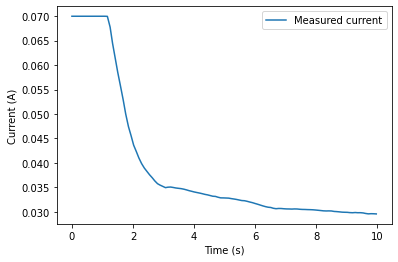

In [19]:
plt.plot(aggregate_data['times'],aggregate_data['measured_currents'],label='Measured current')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
# plt.ylim(-5e-5,5e-5)
# plt.ylim(-current_limit,current_limit)
plt.legend()
plt.show()

In [20]:
#Turn off output and drain capacitors
print("\nSetting source voltage to 0 V")
vsource.write("smua.source.levelv = 0")

print("Turning off output")
vsource.write("smua.source.output = 0")

print("Closing Keithley connection")
vsource.close()



Setting source voltage to 0 V
Turning off output
Closing Keithley connection
